In [1]:
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0,])# 入力
W = np.random.randn(7, 3) # 重み
h = np.dot(c, W)# 中間ノード
print(h)

[-1.70660006 -0.01860078 -0.32260609]


* # CBOWモデルの推論処理

活性化関数を使わないシンプルな処理

In [8]:
import sys 
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# サンプルのコンテキストデータ
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)


print(s)                        

[ 0.85778382 -2.2037786   0.83529863  0.29010852  1.04533196 -0.84494044
 -1.6295598 ]


## コーパスからコンテキストとターゲットを作る関数

In [13]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [15]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


<img src='./figures/corpus-to-context.jpeg'>

### 上の図みたいになるようにコンテキストとターゲットを生成する関数

In [32]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size] # (window_sizeが1の時)一番前と後ろを削る
    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        # 各ターゲットに対してコンテキストを生成
        for t in range(-window_size,  window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)
            
        

In [34]:
# 動作チェック
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [36]:
print(target)

[1 2 3 4 1 5]


## 3.3.2 One-hot表現への変換

In [55]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)


vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# テスト
print(contexts)


[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


いい感じに動いてる〜

# 3.4 CBOWモデルの実装

<img src='./figures/CBOW.jpeg'>

ターゲットの前後のコンテキストを入力する。その後出力を足して2で割って、さらにMatMulレイヤを通す。その出力をSoftmaxとCross Entropyレイヤにかけて教師あり学習させる。

In [112]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


## 3.4.1 CBOWの学習コードの実装

In [126]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 |  iter 1 / 1 | ti

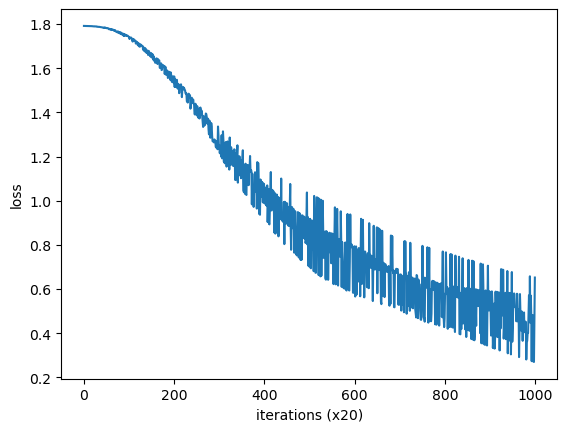

In [128]:
# 損失関数の変化をプロット
trainer.plot()

In [130]:
# 学習後の重みパラメータの確認
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0301248  -0.80082905 -0.8100725   0.76774955  0.99414575]
say [ 0.82157177  0.8384154   0.8464778  -0.849327    0.85775644]
goodbye [-0.390057   -0.88058484 -0.812249    0.85340065 -0.11833909]
and [ 0.858246   0.8420194  0.8387336 -0.863366   0.8562494]
i [-0.3800875  -0.89483273 -0.844432    0.8794247  -0.14538944]
hello [ 1.0309143  -0.7816265  -0.79457754  0.7701239   0.9832991 ]


#### 単語を「密なベクトル」で表すことができた！もう少し大きなコーパスに対して学習させれば「真の」単語のベクトル表現が手に入る

# 3.5.2 skip-gramモデル

<img src='./figures/skip-gram-and-CBOW.jpeg'>

skip-gramモデルはCBOWのちょうど「逆」の推論問題になっている。

<img src='./figures/skip-gram.jpeg'>

skip-gramモデルでは、コンテキストのt番目の単語を$w_t$として、次の式をモデル化している。
$$ P(w_{t-1}, w_{t+1} | w_t) $$
さらに、skip-gramモデルではコンテキストの単語の間に関連性がない（「条件付き独立」を仮定）とする。この時、
$$ P(w_{t-1}, w_{t+1} | w_t)  = P(w_{t-1}|w_t) P(w_{t+1}|w_t)$$

と分解できる。したがって損失関数は、
$$ L = -(\log P(w_{t-1}|w_t) + \log P(w_{t+1}|w_t))$$
と求められる。

一般に、CBOWモデルとskip-gramモデルではskip-gramモデルの方が優れた結果（単語の分散表現）が得られることが多い。